In [10]:
import numpy as np


def _normalize_per_hash(vals, hashes, normalize=False, axis=None):
    for i, net_hash in enumerate(np.unique(hashes)):
        filtered = vals[hashes == net_hash]
        
        if normalize:
            mean, std = np.mean(filtered, axis=axis), np.std(filtered, axis=axis)
            filtered = (filtered - mean) / std
        else:
            hmax = np.max(filtered, axis=axis)
            filtered /= hmax

def scale(values, hashes, labels, per_label=False, inplace=False, normalize=False, axis=None):
    if not inplace:
        values = values.copy()
        
    if per_label:
        for i in np.unique(labels):
            labelmap = labels == label

            label_hashes = hashes[labelmap]
            label_vals = values[labelmap]

            _normalize_per_hash(label_vals, label_hashes, normalize=normalize, axis=axis)
    else:
        _normalize_per_hash(values, hashes, normalize=normalize, axis=axis)
        
    return values

In [2]:
import numpy as np

from info_nas.datasets.io.semi_dataset import labeled_network_dataset
from info_nas.datasets.io.transforms import SortByWeights


def get_dataset_for_plotting(dataset, include_bias=True, fixed_label=None, print_freq=50000,
                             return_all_features=False):
    
    sorter = SortByWeights(include_bias=include_bias, fixed_label=fixed_label,
                           return_all_features=return_all_features)

    train_dataset = labeled_network_dataset(dataset, transforms=sorter,
                                            return_hash=True, return_ref_id=True)

    outputs = []
    labels = []
    hashes = []
    ref_ids = []

    print(f"Dataset length: {len(train_dataset)}")
    for i, b in enumerate(train_dataset):
        if i % print_freq == 0:
            print(i)

        outputs.append(b[3].cpu().numpy())
        labels.append(b[4])
        hashes.append(b[7])
        ref_ids.append(b[8])
        
    del train_dataset

    outputs = np.array(outputs)
    labels = np.array(labels)
    hashes = np.array(hashes)
    ref_ids = np.array(ref_ids)
    
    return outputs, labels, hashes, ref_ids

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


def filter_data(outputs, labels, hashes, ref_ids, label=None, net_hash=None, ref=None):
    
    hashmap = hashes == net_hash if net_hash is not None else hashes == hashes
    labelmap = labels == label if label is not None else labels == labels
    refmap = ref_ids == ref if ref is not None else ref_ids == ref_ids
    
    omap = np.logical_and(hashmap, labelmap, refmap)

    return outputs[omap], labels[omap], hashes[omap], ref_ids[omap]

In [4]:
def plot_heatmap(values, n_features=None, figsize=None, fname=None):
    values = values[:n_features] if n_features is not None else values
    
    plt.figure(figsize=figsize)
    sns.heatmap(values)
    plt.tight_layout()
    
    if fname is not None:
        plt.savefig(fname)
    
    plt.show()
    plt.close()

In [21]:
def get_net_diff(hash_1, hash_2, o_data, label=None):
    o_data_1, _, _, _ = filter_data(*o_data, net_hash=hash_1)
    o_data_2, _, _, _ = filter_data(*o_data, net_hash=hash_2)
    
    return np.sum(np.mean((o_data_1 - o_data_2) ** 2, axis=1))


def get_error_matrix(outputs, labels, hashes, ref_ids, label=None, print_freq=20, n_feats=None):
    all_hashes = np.unique(hashes)
    size = len(all_hashes)

    if n_feats is not None:
        outputs = outputs[:, :n_feats]
    o_data = filter_data(outputs, labels, hashes, ref_ids, label=label)
    
    errors = np.zeros((size, size))

    for i, ival in enumerate(all_hashes):
        if i % print_freq == 0:
            print(i)
        
        for j, jval in enumerate(all_hashes):
            if i >= j:
                continue
            
            errors[i, j] = get_net_diff(ival, jval, o_data, label=label)
            
    return errors

In [6]:
seed = 1

from nasbench import api

nasbench_path = '../data/nasbench_only108.tfrecord'
nb = api.NASBench(nasbench_path)

import glob
import os

train_pretrained = glob.glob('../../../pretrained_nets/hashes/train_hashes_100_splits/out_?/')
train_pretrained += glob.glob('../../../pretrained_nets/hashes/train_hashes_100_splits/out_??/')

val_pretrained = glob.glob('../../../pretrained_nets/hashes/valid_hashes_60_splits/out_?/')
val_pretrained += glob.glob('../../../pretrained_nets/hashes/valid_hashes_60_splits/out_??/')
val_pretrained

import torch
from info_nas.datasets.arch2vec_dataset import get_labeled_unlabeled_datasets

#torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# device = None otherwise the dataset is save to the cuda as a whole
labeled, unlabeled = get_labeled_unlabeled_datasets(nb, device=device, seed=seed,
                                                    train_pretrained=train_pretrained,
                                                    valid_pretrained=val_pretrained,
                                                    train_labeled_path='../data/train_long.pt',
                                                    valid_labeled_path='../data/valid_long.pt')

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 36 seconds
Loading nasbench dataset (arch2vec) from ../data/nb_dataset.json
Processing labeled nets for the training set...
Loading labeled dataset from ../data/train_long.pt.
Processing labeled nets for the validation set...
Loading labeled dataset from ../data/valid_long.pt.


In [7]:
train = labeled['train']
del labeled
del unlabeled

import gc
gc.collect()

0

In [24]:
normalize = False
axis = None
n_feats = 100

err_dict = {}

for sort_label in range(10):
    outputs, labels, hashes, ref_ids = get_dataset_for_plotting(train, fixed_label=sort_label)
    outputs = scale(outputs, hashes, labels, normalize=normalize, axis=axis)
    
    err_dict[sort_label] = get_error_matrix(outputs, labels, hashes,
                                            ref_ids, label=sort_label,
                                            n_feats=n_feats)

Dataset length: {len(train_dataset)}
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
Dataset length: {len(train_dataset)}
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
Dataset length: {len(train_dataset)}
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
Dataset length: {len(train_dataset)}
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
Dataset length: {len(train_dataset)}
0
5

In [27]:
import pickle

with open('err.pickle', 'wb') as f:
    pickle.dump(err_dict, f)

In [30]:
with open('err.pickle', 'rb') as f:
    a = pickle.load(f)
a[0].shape

(608, 608)

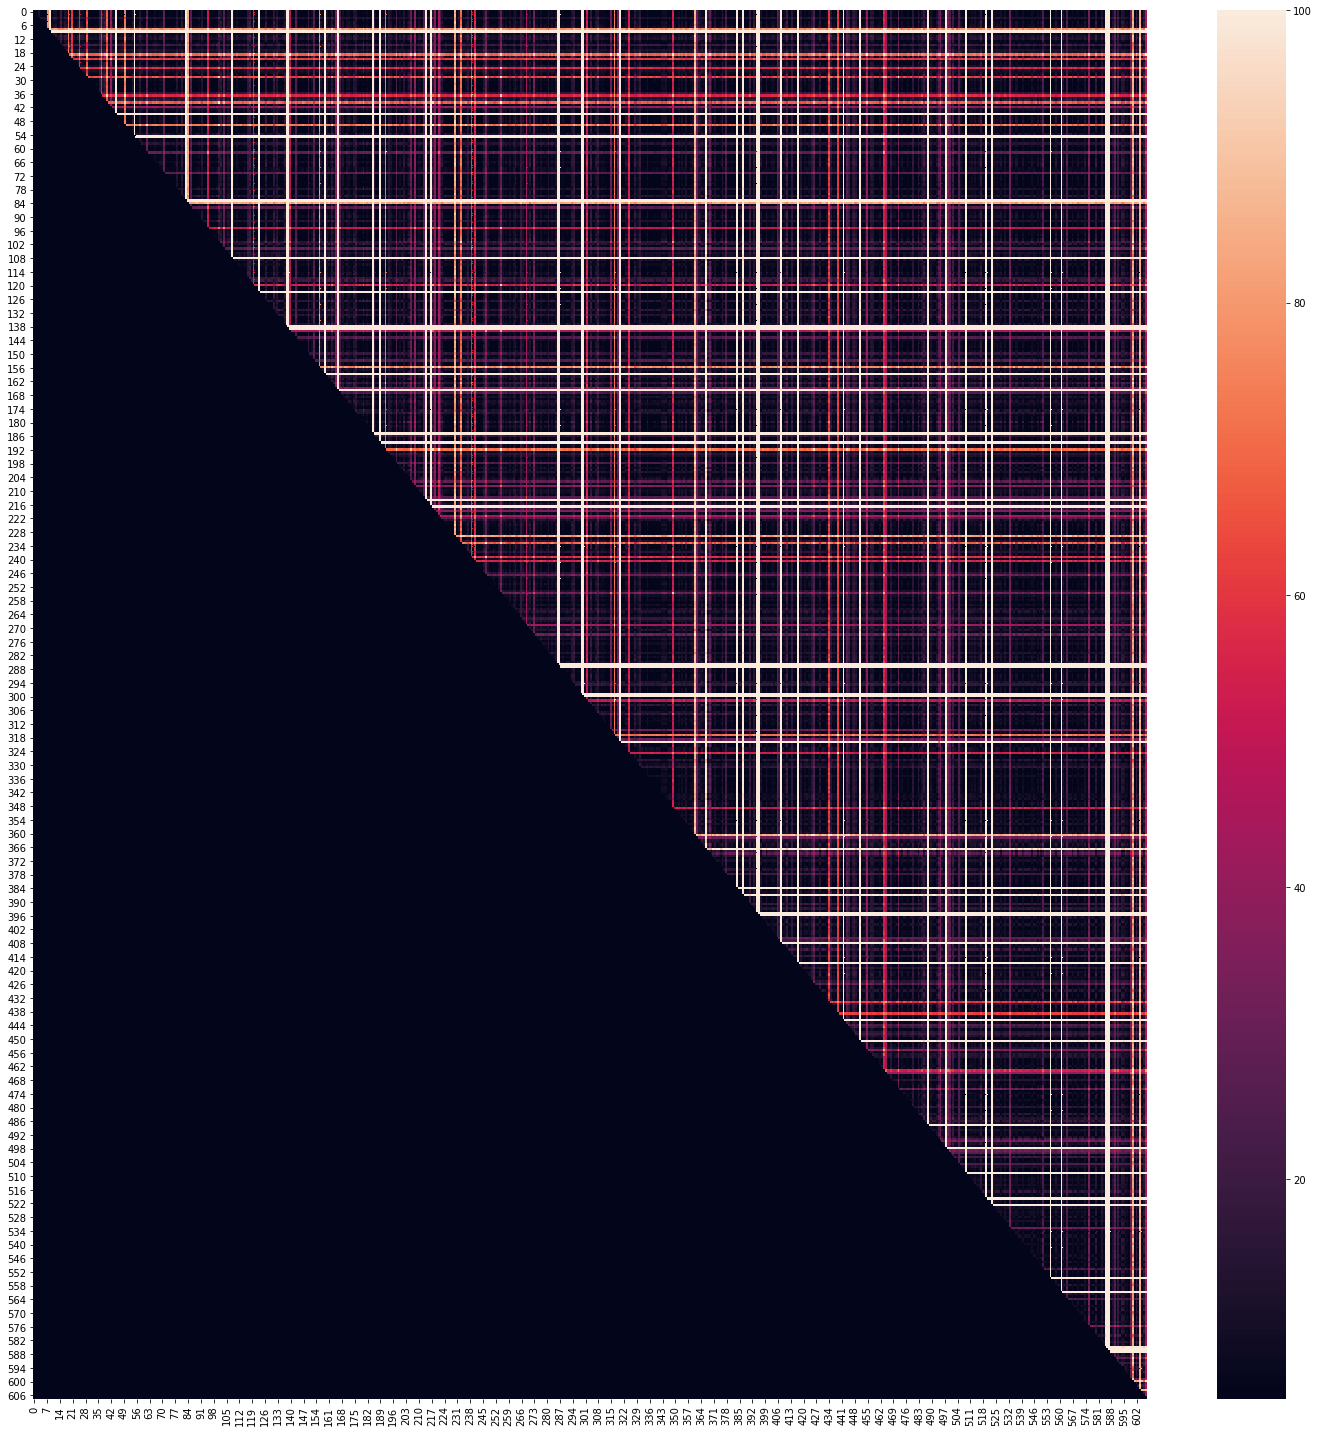

In [103]:
stacked_a = np.array([v for v in a.values()])

plotf = (stacked_a - stacked_a.mean(axis=0)).std(axis=0)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
sns.heatmap(plotf, vmin=5, vmax=100)
plt.tight_layout()
plt.show()
plt.close()

In [135]:
m = stacked_a.mean(axis=0)
m = m[m > 0]
m = m[m < 50]
len(m)

111511

/home/gabi/anaconda3/envs/pyt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


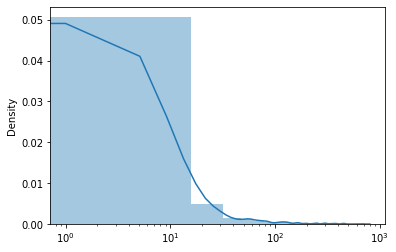

In [107]:
mm = (stacked_a - stacked_a.mean(axis=0)).std(axis=0)

plt.figure()
ax = sns.distplot(mm)
ax.set_xscale('log')
plt.show()

In [ ]:
# TODO axis asi 1? normalize True